In [1]:
#Library imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
from datetime import datetime, timedelta

In [2]:
#Import local database interface 

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from Database.ca_mysqldb import MySQLConnector


In [3]:
#Wrapper function for the database interface

def queryDB(query, labels):
    db = MySQLConnector()
    out = db.execute(query)
    db.close()
    return pd.DataFrame.from_records(out, columns=labels)

COURSES_ID = "('EPFL-AlgebreLineaire-2017_T3', 'EPFL-AlgebreLineaire-2018')"

In [4]:
# Helper function used to select columns from a table
# Without it, it is needed to duplicate the column names for the MySQL query
# and the from_records columns argument

def selectColumns(columns, table, *args):
    query = "SELECT "
    for col in columns:
        query += col + ", "
    query = query[:-2] # remove last comma
    query += " FROM ca_courseware." + table +" "
    if(args):
        query += "LIMIT " + str(args[0])

    db = MySQLConnector()
    out = db.execute(query)
    db.close()
    if "*" in columns:
        return pd.DataFrame.from_records(out)
    else:
        return pd.DataFrame.from_records(out, columns=columns)

## User Location

Let's start by analyzing the different countries from which the MOOC has been watched over 2018 and 2019.

In [5]:
query = """
SELECT Country, count(AccountUserID) as NumberOfUser
FROM ca_courseware.User_Location Location
WHERE DataPackageID in {}
GROUP BY Country
ORDER BY NumberOfUser DESC;
""".format(COURSES_ID)

df = queryDB(query,["Country", "Number of User"])
print("Number of distinct countries: "+str(df.size))


Number of distinct countries: 72


In [6]:
df.head(10)

,Country,Number of User
0,Switzerland,808
1,France,128
2,Netherlands,60
3,United States,24
4,Mauritius,21
5,Morocco,12
6,United Kingdom,8
7,Algeria,8
8,Spain,5
9,Tunisia,5


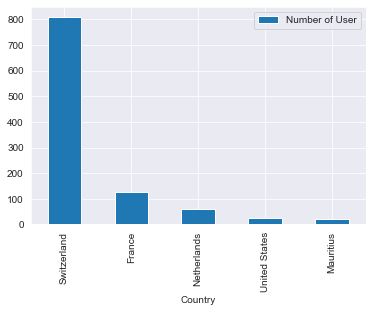

In [7]:
df.head().plot(x = "Country", kind = "bar")

As expected, most of the users are located in Switzerland, where EPFL is located, and in French speaking countries.
Note that a single user can have multiple locations if he watches the MOOC from different countries.

Let's now zoom out to the continent scale.

In [8]:
query = """
SELECT Continent, count(AccountUserID) as NumberOfUser
FROM ca_courseware.User_Location Location
WHERE DataPackageID in {}
GROUP BY Continent
ORDER BY NumberOfUser DESC;
""".format(COURSES_ID)

df = queryDB(query, ["Continent", "Number of user"])
df

,Continent,Number of user
0,Europe,1028
1,Africa,61
2,Americas,28
3,Asia,8


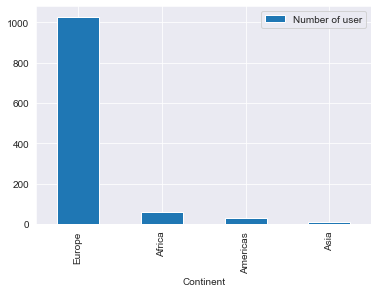

In [9]:
df.plot(x="Continent", kind="bar")

Not surprisingly Europe is still first. Let's notice that the African continent comes second even if the first non-european country is the United States. 
Some possible explanations:
* Africa contains more countries
* Africa contains more french speaking countries
* Even if the United States is the first non-european country, it is followed closely by Morocco.

## Video Events

Let's now check the different events recorded during the videos.

In [10]:
query ="""
SELECT DISTINCT EventType, count(*) AS Occurences FROM ca_courseware.Video_Events
WHERE DataPackageID in {}
GROUP BY EventType
ORDER BY OCCURENCES DESC
""".format(COURSES_ID)
df = queryDB(query, ["Events", "Occurences"])
df

,Events,Occurences
0,Video.Play,183821
1,Video.Pause,134412
2,Video.Seek,64068
3,Video.Transcript.Translate.EN,33554
4,Video.Load,32105
5,Video.Stop,12990
6,Video.SpeedChange,4974
7,Video.Transcript.Hide,667
8,Video.Transcript.Show,379
9,Video.Transcript.Download,185



Some interesting facts to look into:
* The most usual speed change amount, do people with high grades usually slow down or speed up the video?
* Does using the transcript helps getting better performance? Or is it the opposite?
* Correlation between the number of times a student watched the videos and performance?
* Does "Pause to ponder" help?

For now let's just plot the available facts: the speed change amount, the replay amount and the process the "pause to ponder" event.

### Speed Change 

In [11]:
query ="""
SELECT (NewSpeed - OldSpeed) AS SpeedChange, count(*) AS Occurences, OldSpeed, NewSpeed FROM ca_courseware.Video_Events
WHERE DataPackageID in {}
AND OldSpeed is not null AND NewSpeed is not null
AND OldSpeed != NewSpeed
GROUP BY SpeedChange
ORDER BY SpeedChange DESC
""".format(COURSES_ID)
df = queryDB(query, ["SpeedChange", "Occurences","OldSpeed", "NewSpeed"])
df

,SpeedChange,Occurences,OldSpeed,NewSpeed
0,1.50,22,0.50,2.00
1,1.25,7,0.75,2.00
2,1.00,226,1.00,2.00
3,0.75,184,1.25,2.00
4,0.50,1024,0.50,1.00
5,0.25,1254,1.25,1.50
6,-0.25,924,1.25,1.00
7,-0.50,843,2.00,1.50
8,-0.75,206,2.00,1.25
9,-1.00,250,2.00,1.00


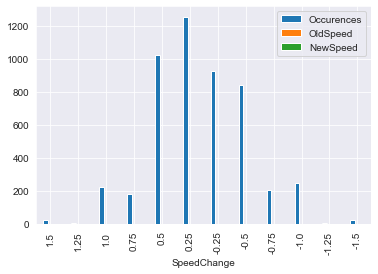

In [12]:
df.plot(x="SpeedChange", kind="bar")

### Number of videos watched and replay average
Let's see the how many videos a student usually watch during the MOOC.

In [13]:
query ="""
SELECT AccountUserID, VideoID, DataPackageID, from_unixtime(TimeStamp, '%Y-%m-%d') FROM ca_courseware.Video_Events
WHERE DataPackageID in {}
""".format(COURSES_ID)
df = queryDB(query, ["AccountUserID", "VideoID", "DataPackageID", "TimeStamp"])


#### How many videos did each student watch?

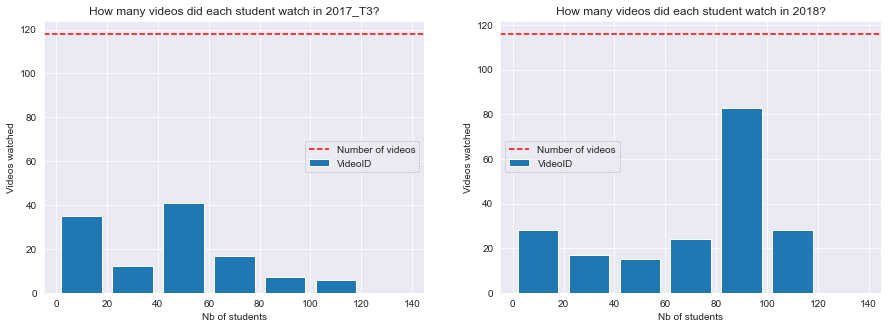

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

for i in range(0,2):
    year = '2017_T3' if i == 0 else '2018'
    video_df = df[df["DataPackageID"] == 'EPFL-AlgebreLineaire-{}'.format(year)][['AccountUserID', 'VideoID']].drop_duplicates()
    hist = video_df.groupby('AccountUserID').count().plot(ax=axes[i], kind='hist', bins=[0, 20, 40, 60, 80, 100, 120, 140], rwidth=0.8, title="How many videos did each student watch in {}?".format(year))
    hist.axhline(video_df.VideoID.nunique(),color='r', label="Number of videos",linestyle='dashed')
    hist.set_xlabel("Nb of students")
    hist.set_ylabel("Videos watched")
    hist.legend()


We can see here the repartition of students who watched a certain amount of videos in 2018 and 2019. We are counting only distinct videos, thus watching multiple times the same video doesn't increase the count.

**Q:** How is possible that no student watched every video?

A possible answer could be a mistake in the data interpretation

#### How many times a video is usually replayed?

In [15]:

rewatch_count = df.drop_duplicates().pivot_table(index=['AccountUserID','VideoID'], aggfunc='size')
print("In average, a video is watched {:.2f} times by students.".format(rewatch_count.mean()))


In average, a video is watched 1.35 times by students.


### Pause to ponder

Let's call "pause to ponder" when a student pauses the video for a relatively small amount of time to think and ponder about the material. Let's try to find a rational time range.


In [16]:
query ="""
SELECT AccountUserID, VideoID, from_unixtime(TimeStamp, '%Y-%m-%d %H:%i:%S'),EventType, CurrentTime FROM ca_courseware.Video_Events
WHERE DataPackageID in {}
AND EventType in ('Video.Play', 'Video.Pause')
""".format(COURSES_ID)
df = queryDB(query, ["AccountUserID", "VideoID", "TimeStamp", "EventType","CurrentTime"])


In [17]:
df.head()

,AccountUserID,VideoID,TimeStamp,EventType,CurrentTime
0,9893,4d31551afe0e437e9efb0de334c8267c,2017-11-01 17:52:03,Video.Play,184.694
1,9914,a48d8f0bbac04689a88f8b06cf53154e,2017-10-23 16:44:50,Video.Play,603.000
2,12494,7ad7b082ef9149f280e3d7b9be2aa348,2017-11-10 16:51:42,Video.Play,202.526
3,9923,cea9957b2f57401bbb75e15230dfaadc,2017-11-14 18:59:06,Video.Play,613.206
4,9950,eea23d4f240749cab1f65b449e21df1e,2017-11-30 18:38:24,Video.Play,331.000


Let's convert string dates to datetime objects to make date comparison easier:

In [18]:

pause_df = df.copy()
pause_df['TimeStamp'] = pause_df['TimeStamp'].apply(lambda date: datetime.strptime(date, "%Y-%m-%d %H:%M:%S")) 
pause_df = pause_df.sort_values(by="TimeStamp", ascending=False)


In [19]:
pause_df.head(10)

,AccountUserID,VideoID,TimeStamp,EventType,CurrentTime
284798,46440,8a949761e19248f7b4fcd08d136b0a53,2020-02-15 12:37:01,Video.Play,755.535
152559,46440,8a949761e19248f7b4fcd08d136b0a53,2020-02-15 12:34:13,Video.Pause,755.471
300766,46440,8a949761e19248f7b4fcd08d136b0a53,2020-02-15 12:34:09,Video.Play,751.018
201398,46440,8a949761e19248f7b4fcd08d136b0a53,2020-02-14 16:58:55,Video.Pause,750.990
173737,46440,8a949761e19248f7b4fcd08d136b0a53,2020-02-14 16:58:14,Video.Play,710.556
123525,46440,8a949761e19248f7b4fcd08d136b0a53,2020-02-14 16:57:27,Video.Pause,710.529
288413,46440,8a949761e19248f7b4fcd08d136b0a53,2020-02-14 16:55:07,Video.Play,571.720
138827,46440,8a949761e19248f7b4fcd08d136b0a53,2020-02-14 16:55:01,Video.Pause,571.817
268193,46440,8a949761e19248f7b4fcd08d136b0a53,2020-02-14 16:54:30,Video.Play,540.907
140445,46440,8a949761e19248f7b4fcd08d136b0a53,2020-02-14 16:54:15,Video.Pause,540.868


We now have to create a new column with the time duration of the pause for each Pause event. We know that a pause event is followed by a play event. By sorting the events in a descending order (opposite of chronological), we know that a play is always followed by a pause. Thus, we can compute the pause duration: previous play timestamp - current pause timestamp.

In [20]:
# The previous play timestamp is saved in the global variable prev_ts
# The function computes the time difference between the current pause event 
# and the previously saved play timestamp
# If the event is a play, we save its timestamp and return NaN
# otherwise it is a pause and we compute the pause duration
def compute_duration(event, ts):
    global prev_ts
    temp = prev_ts

    if event  == 'Video.Play':
        prev_ts = ts
        return np.nan
    else : 
        return temp - ts
#The initial value of prev_ts is the first value of the sorted table 
# so that in case the table it starts with a Pause event (i.e. the user left the video during a pause)
# the pause duration is 0
prev_ts = pause_df.iloc[0,2]
print("The initial value of prev_ts is {}".format(prev_ts))

The initial value of prev_ts is 2020-02-15 12:37:01


In [21]:

#Create the column PauseDuration by applying the compute_duration function on each row
pause_df['PauseDuration'] = pause_df.apply(lambda x:compute_duration(x['EventType'],x['TimeStamp']), axis=1)
#Filter out NaT values, i.e Play events
pause_df.dropna(subset=['PauseDuration'], inplace=True) 
#Only keep pause duration time ranging from 0 to 20 minutes to exclude the actual breaks or when the user leave the video on pause
pause_df = pause_df[(pause_df['PauseDuration'] > timedelta(seconds=0)) &(pause_df['PauseDuration'] < timedelta(minutes=20))]


In [22]:
pause_df.head()

,AccountUserID,VideoID,TimeStamp,EventType,CurrentTime,PauseDuration
152559,46440,8a949761e19248f7b4fcd08d136b0a53,2020-02-15 12:34:13,Video.Pause,755.471,00:02:48
123525,46440,8a949761e19248f7b4fcd08d136b0a53,2020-02-14 16:57:27,Video.Pause,710.529,00:00:47
138827,46440,8a949761e19248f7b4fcd08d136b0a53,2020-02-14 16:55:01,Video.Pause,571.817,00:00:06
140445,46440,8a949761e19248f7b4fcd08d136b0a53,2020-02-14 16:54:15,Video.Pause,540.868,00:00:15
112046,46440,8a949761e19248f7b4fcd08d136b0a53,2020-02-14 16:53:20,Video.Pause,522.781,00:00:36


count    125595.000000
mean          0.590362
std           1.405603
min           0.016667
25%           0.083333
50%           0.216667
75%           0.533333
max          19.966667
Name: PauseDuration, dtype: float64

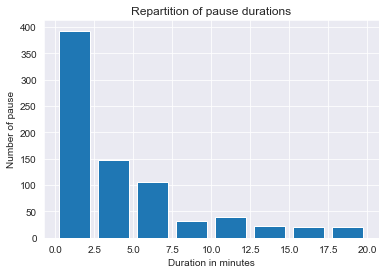

In [23]:
#Convert timedelta to int
hist_df = pause_df['PauseDuration'].apply(lambda x: x.seconds/60)
hist = hist_df.groupby(pause_df['PauseDuration']).count().plot( kind='hist', bins=[0, 2.5, 5,7.5,10,12.5,15,17.5,20], rwidth=0.8, title="Repartition of pause durations")
hist.set_xlabel("Duration in minutes")
hist.set_ylabel("Number of pause");
hist_df.describe()

### Pause counts

Counting the number of pauses made by a student while watching a video is a feature of their behavior. A large amount of pauses may be associated with attention or difficulties to understand the material while little pauses may illustrate ease or poor attention.

## Regularity

Let's focus on the regularity with which the students watch the MOOC. From a week, day and hour perspectives, when do the students usually watch the videos? Are there any pattern linked to performance?

Reference: <a href="https://rdcu.be/b6VLF">How to Quantify Student's Regularity?</a>


In [24]:

query ="""
SELECT AccountUserID, VideoID, from_unixtime(TimeStamp, '%Y-%m-%d') as Day, from_unixtime(TimeStamp, '%H') as Hour 
FROM ca_courseware.Video_Events
WHERE DataPackageID in {}
AND EventType='Video.Play'
AND CurrentTime < 1
GROUP BY AccountUserID, VideoID, Day
""".format(COURSES_ID)
df = queryDB(query, ["AccountUserID", "VideoID", "Day", "Hour"])



### Week repartition

In [25]:
# Converts a date string to a datetim object
def string_to_datetime(ts):
    return datetime.strptime(ts, '%Y-%m-%d')

# Converts a datetime object to the week number (as a string)
def datetime_to_week(dt):
    return dt.strftime('%W')

# Drop the rows containing a date outside of the given dates
def drop_date_outsiders(series, start_date, end_date):
    start_dt = string_to_datetime(start_date)
    end_dt = string_to_datetime(end_date)
    return series[(series >= start_dt) & (series <= end_dt)]

# Reorder the week numbers such that 0 it the starting week of the mooc (and not the first week of January)
def order_week(series, start_date):
    start_week = int(datetime_to_week(string_to_datetime(start_date)))
    nb_week = int(series.max())
    return series.apply(lambda w: str((int(w) - start_week) % nb_week))

# Removes the viewings outside of the Mooc duration, around 15 weeks
# and labels the week by number and ordered
def processYear(series, start_date, end_date):
    series = series.apply(string_to_datetime)
    series = drop_date_outsiders(series, start_date, end_date)
    series = series.apply(datetime_to_week)
    return order_week(series,start_date)
    

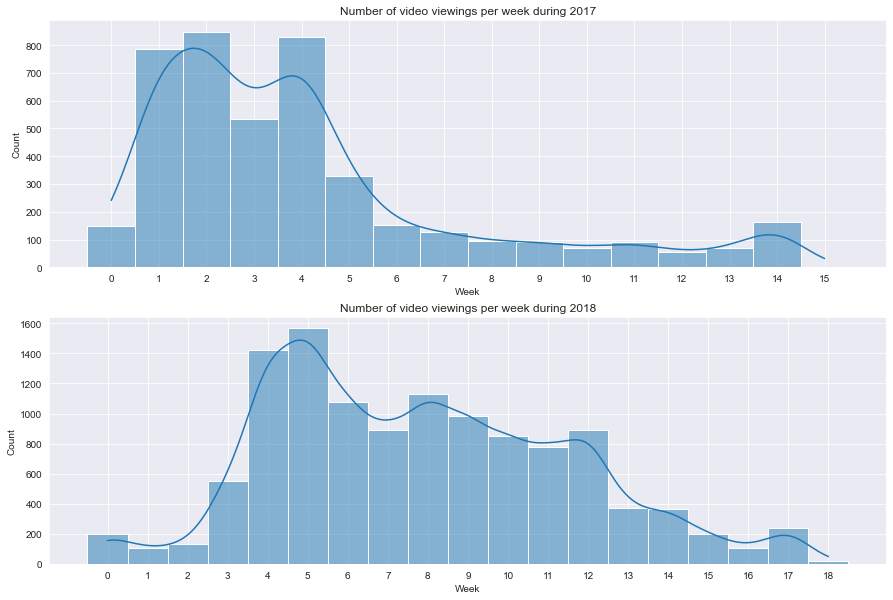

In [26]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15,10))

for i in range(0,2):
    start_date = '2017-10-12' if(i == 0) else '2018-09-17'
    end_date = '2018-01-28' if(i==0) else '2019-01-28'
    course_df = df[['Day','AccountUserID']].copy()
    course_df['Week'] = processYear(course_df['Day'], start_date, end_date)
    course_df = course_df.dropna().sort_values(by="Day");
    chart = sns.histplot(ax=axes[i], data=course_df,x="Week", kde=True, palette="crest");
    chart.set_title("Number of video viewings per week during "+('2017' if(i==0) else '2018'))

### Weekdays repartition
Before diving into the features recommended by Boroujeni et al. let's explore the time repartition of the viewings over the week and the day. Let's define a video viewing as the event Video.Play occurring before the first second of the video. Only one viewing per day is taken into account.

In [27]:
#Converts a string date to the corresponding day of the week
def string_to_day(ts):
    return datetime.strptime(ts, '%Y-%m-%d').strftime('%A')

week_df = df[['Day','AccountUserID']].copy()
week_df["Day"] = week_df['Day'].apply(string_to_day)


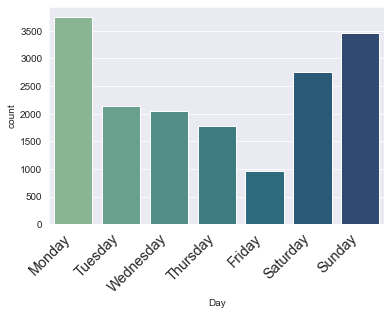

In [28]:
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

chart = sns.countplot(data=week_df, x="Day", order=days, palette="crest");
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right', fontweight='light', fontsize='x-large');

**Comment:** The peak days are Monday and the weekend. The latter is not surprising since it is when the students have the most time to dedicate. An hypothesis for the large amount of viewings on Monday is that the videos are released on Monday or that come quiz takes place around that day.

### Hours repartition

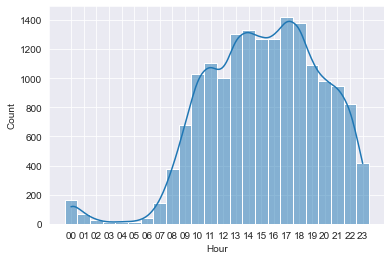

In [29]:

sns.histplot(data=df[['Hour', 'AccountUserID']].sort_values(by="Hour"),x="Hour", kde=True);